In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.signal import stft, detrend
from scipy.ndimage import uniform_filter1d
from scipy.signal import spectrogram
import librosa
import librosa.display

## ETL

In [2]:
# All: 40000 rows, 50%: 20000 rows, 10%: 4000 rows
nr_rows = 30000
df = pd.read_csv('./data/all.csv', nrows=nr_rows)

# Extract torque and angle outside the loop
torque_data = df["Torque"].apply(json.loads)
angle_data = df["Angle"].apply(json.loads)

torque_array = []
whole_rotation = []
first_rotation = []
second_rotation = []

for sample in range(0, nr_rows):
    torque = pd.DataFrame(torque_data[sample][0]['Rows'], columns=["Time", "Torque"])
    torque = torque.drop(columns=["Time"])
    angle = pd.DataFrame(angle_data[sample][0]['Rows'], columns=["Time", "Angle"])

    total_data = pd.concat([angle, torque], axis=1)
    total_data['Kleiner_als_vorher'] = total_data["Angle"] > total_data["Angle"].shift(1)
    total_data['Kumulatives_Produkt'] = (total_data['Kleiner_als_vorher'][1:].astype(int)).cumprod()

    resultat = total_data[total_data['Kumulatives_Produkt'] == 1]
    resultat2 = total_data[total_data['Kumulatives_Produkt'] == 0]
    resultat2 = resultat2.reset_index()

    resultat = resultat.drop(columns=["Time", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])
    resultat2 = resultat2.drop(columns=["Time", "index", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])

    # Ensure both dataframes have the same shape by truncating or padding
    whole_len = 1800
    max_len = 836  # Define the target length
    resultat = resultat.head(max_len).reindex(range(max_len), fill_value=0)
    resultat2 = resultat2.head(max_len).reindex(range(max_len), fill_value=0)


    first_rotation.append(resultat)
    second_rotation.append(resultat2[30:836])

    total_data = total_data.drop(columns=["Time", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])
    total_data = total_data.head(max_len).reindex(range(whole_len), fill_value=0)
    whole_rotation.append(total_data)

    torque_array.append(torque)

# First Rotation
data = np.array(first_rotation)
squeezed_arr = np.squeeze(data)

# Second Rotation - The rotatiion where Frequencies are different
data2 = np.array(second_rotation)
squeezed_arr2 = np.squeeze(data2)

# Whole Rotation
data3 = np.array(whole_rotation)
whole_rotation_arr = np.squeeze(data3)

In [3]:
# Stats on data
print("Number of sample first rotation = ", len(squeezed_arr))
print("Number of sample second rotation = ", len(squeezed_arr2))

print("Number of sample total= ", len(whole_rotation_arr))

Number of sample first rotation =  30000
Number of sample second rotation =  30000
Number of sample total=  30000


## Compute Mel's Spectogram Features

In [13]:
# Plot Or No
PLOT_RESULTS = False
# Parameter's for Mel's Features
sample_rate = 5000
n_mels = 128
fmax = 2000
hop_length = 64

mel_torques = {}
mel_labels = {}

def compute_mel_spectrogram(data, sr=5000, hop_length=128, n_mels=40, cmap='magma'):
    S = librosa.feature.melspectrogram(y=data, sr=sr, hop_length=hop_length, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB


for i in range(nr_rows):
    mel_features = compute_mel_spectrogram(whole_rotation_arr[i], sr=sample_rate, hop_length=hop_length, n_mels=n_mels)
    mel_torques[i]= mel_features
    mel_labels[i] = 1
    #print(mel_features.shape)
    if PLOT_RESULTS:
        plt.figure(figsize=(6, 4))
        librosa.display.specshow(mel_features, sr=sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel-frequency spectrogram for sample {i}")
        plt.tight_layout()
        plt.show()

/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1800
  warnings.warn(


## Inference SVM Classifier

In [14]:
from sklearn.svm import SVC
import pickle 

svm_classifier = pickle.load(open('svm_classiferv1', 'rb'))
svm_labels = {}

for sample_nr, features in mel_torques.items():
        # Reshape to match trained model's input dimensions
        features = features[:, :27].flatten()
        features = features.reshape(1, -1)
        #print(features.shape)
        prediction = svm_classifier.predict(features)
        #print(f'Predicted class: {prediction.item()}')
        svm_labels[sample_nr] = prediction.item()
print("Total Good Cutting Flagged Predictions: ", sum(svm_labels.values()))
print("Total Bad Cutting Flagged Predictions: ", len(svm_labels) - sum(svm_labels.values()))

/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Total Good Cutting Flagged Predictions:  13937
Total Bad Cutting Flagged Predictions:  16063


## Show K-Means Clusters 

In [6]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract good cutting data
good_cutting_data = np.array([mel_torques[key] for key in svm_labels if svm_labels[key] == 1])
bad_cutting_data = np.array([mel_torques[key] for key in svm_labels if svm_labels[key] == 0])
print("good cutting:", good_cutting_data.shape)
print("bad cutting:", bad_cutting_data.shape)

# Flatten the data if needed (depends on clustering approach)
good_cutting_data_flat = good_cutting_data.reshape(good_cutting_data.shape[0], -1)
bad_cutting_data_flat = bad_cutting_data.reshape(bad_cutting_data.shape[0], -1)

# Perform K-Means Clustering
n_clusters = 5  # Choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(good_cutting_data_flat)

# Retrieve cluster labels
cluster_labels = kmeans.labels_

# Print cluster centers and labels
#print("Cluster Centers:\n", kmeans.cluster_centers_)
#print("Cluster Labels:\n", cluster_labels)

good cutting: (13937, 128, 29)
bad cutting: (16063, 128, 29)


/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Elbow Method

/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/sklearn/cluster/_kme

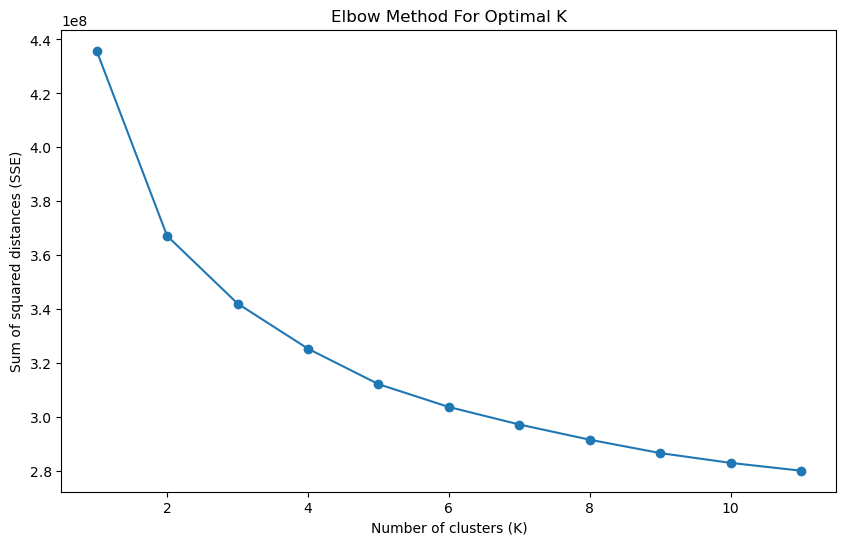

In [7]:
# Determine the optimal number of clusters using the elbow method
sse = []
k_range = range(1, 12)  # You can adjust the range based on your data
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(good_cutting_data_flat)
    sse.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of squared distances (SSE)')
plt.show()

## Plot the K-Means Clusters

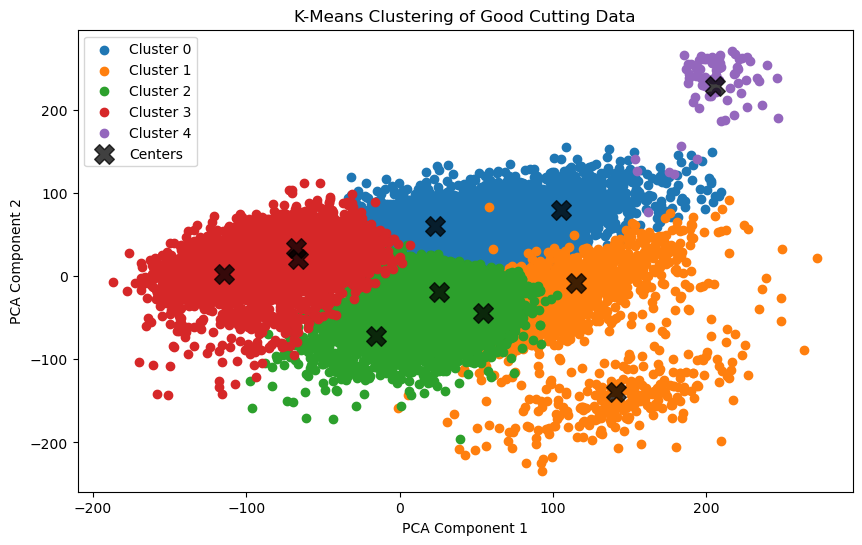

In [17]:
# Reduce dimensions to 2 using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(good_cutting_data_flat)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    plt.scatter(reduced_data[cluster_labels == cluster, 0], reduced_data[cluster_labels == cluster, 1], label=f'Cluster {cluster}')

# Plot cluster centers
centers_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', s=200, alpha=0.75, marker='X', label='Centers')

plt.title('K-Means Clustering of Good Cutting Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

## t-SNE Plot

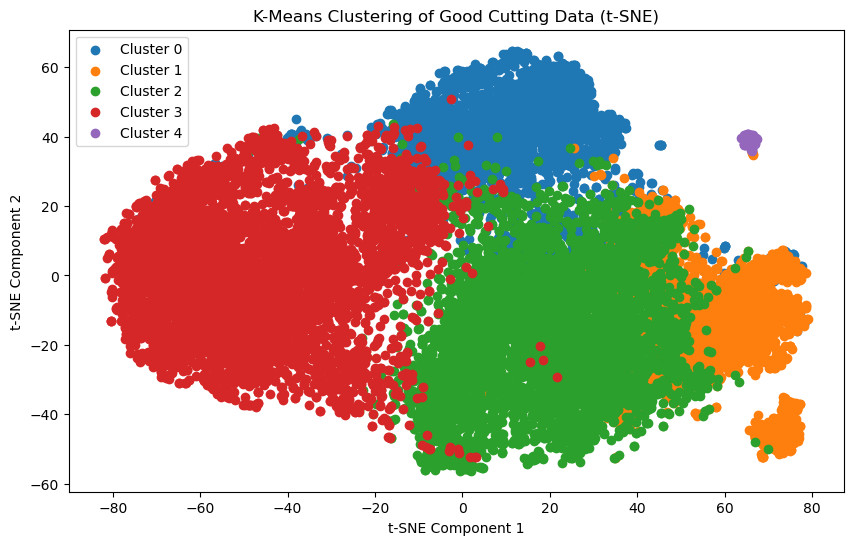

In [9]:
# Reduce dimensions to 2 using t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(good_cutting_data_flat)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    plt.scatter(reduced_data_tsne[cluster_labels == cluster, 0], reduced_data_tsne[cluster_labels == cluster, 1], label=f'Cluster {cluster}')

plt.title('K-Means Clustering of Good Cutting Data (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()